In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
from glob import glob

from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.utils.validation import check_is_fitted
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

<h1><bold>Data Preparation</bold></h1>
<br></br>
<p1> Created a function that does the following:<br></br>
* reads csv file <br>
* subsets data: Aprtments in "Capital Federal", < 400_000 <br>
* Removes outliers for "surface_covered_in_m2" <br>
* Splits "lat-lon" columns <br>
* Get neighborhood name from "place_with_parent_names <br>
* Drop features with null null count <br>
* Drops low,high cardinality categorical variables <br>
* Drops leaky columns <br>
* Drops columns with multicollinearity</p1>

In [83]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    #drop features with high null count
    df.drop(columns =["floor", "expenses"], inplace = True)
    
    #drop low and high cardinality categorical variables
    df.drop(columns=["operation","property_type", "currency", "properati_url"], inplace=True)
    
    #drop leaky columns
    df.drop(columns=[
    'price',
    'price_aprox_local_currency',
    'price_per_m2',
    'price_usd_per_m2'
        
     ],
     inplace = True
)
    
    #drop columns with multicollinearity
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace = True)

    
    return df

<p2> Created a list containing file names for all Buenos csv files</p2>

In [62]:
files = sorted(glob(r"C:\Users\Nonsindiso\Downloads\buenos-aires-real-estate-*.csv"))
files

['C:\\Users\\Nonsindiso\\Downloads\\buenos-aires-real-estate-1.csv',
 'C:\\Users\\Nonsindiso\\Downloads\\buenos-aires-real-estate-2.csv',
 'C:\\Users\\Nonsindiso\\Downloads\\buenos-aires-real-estate-3.csv',
 'C:\\Users\\Nonsindiso\\Downloads\\buenos-aires-real-estate-4.csv',
 'C:\\Users\\Nonsindiso\\Downloads\\buenos-aires-real-estate-5.csv']

<p3> Wrangle all the files and concatenate them into a single DataFrame</p3>

In [63]:

frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


<h1><bold>Data Exploration </bold></h1>

In [64]:
#check number of null values
df.isnull().sum()/len(df)

price_aprox_usd          0.000000
surface_covered_in_m2    0.000000
lat                      0.040413
lon                      0.040413
neighborhood             0.000000
dtype: float64

In [65]:
# check low and high cardinality
df.select_dtypes("object").nunique()

neighborhood    57
dtype: int64

<Axes: >

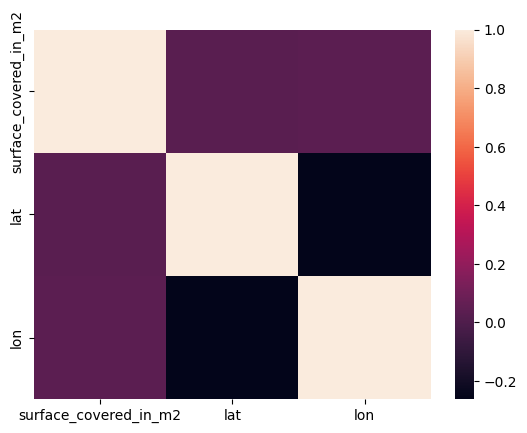

In [66]:
# heatmap for multicollinearity. This eliminates features that are highly correlated amongst themselves 
corr = df.select_dtypes("number").drop(columns = "price_aprox_usd").corr()
sns.heatmap(corr)

<p3> Distribution of apartment prices</p>

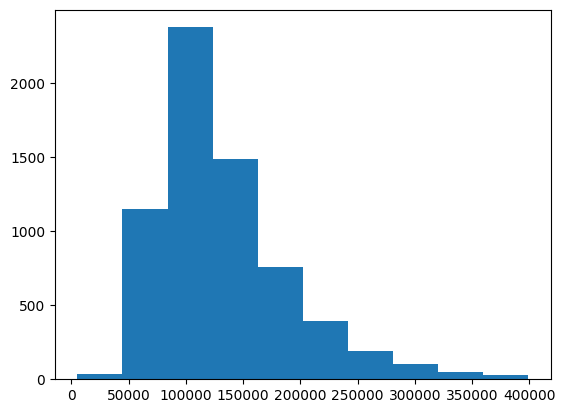

In [88]:
#Histogram showing distribution of apartment prices
plt.hist(df["price_aprox_usd"])

plt.xlabel = ("Price [$]")
plt.ylabel = ("Count")
plt.title = ("Distribution of Apartment Prices")
plt.show()


<p4>Apartment price vs Size </p4>

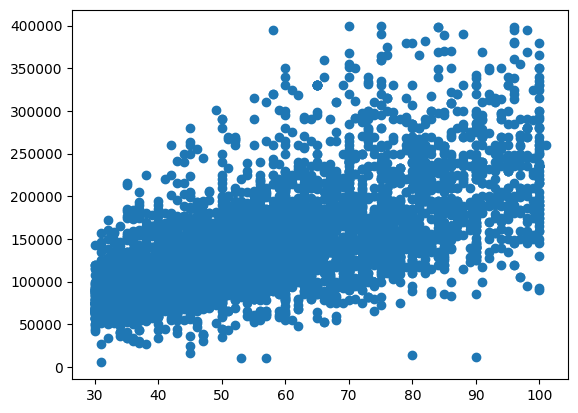

In [68]:
# scatter plot showing the relationship between apartment price vs apartment size 
plt.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])


# Label axes
plt.xlabel = ("Area [sq meters]")
plt.ylabel = ("Price [USD]")
plt.title = ("Mexico City: Price vs. Area")


<p5> Location vs Price</p5>

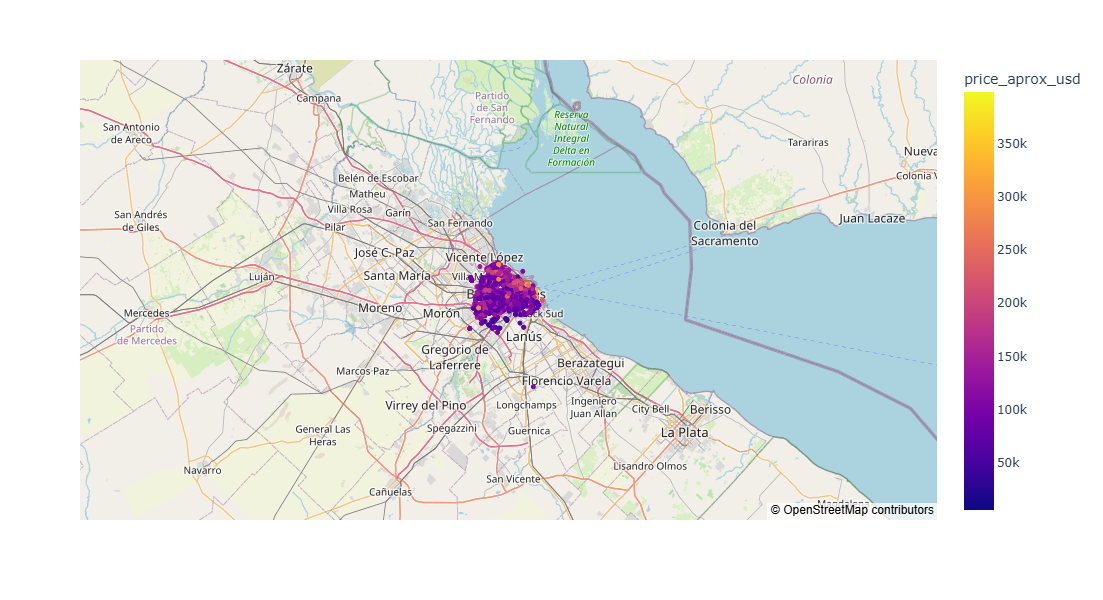

In [80]:
#Plot Mapbox showing location vs price
fig = px.scatter_mapbox(
    df,
    lat = "lat",
    lon = "lon",
    width = 600,
    height = 600,
    color = "price_aprox_usd",
    hover_data = ["price_aprox_usd"],
)

fig.update_layout(mapbox_style = "open-street-map")

<h1> Split Data</h1>

In [ ]:
target = "price_aprox_usd"
feature = ["surface_covered_in_m2","lat","lon","neighborhood"]

X_train = df[feature]
y_train = df[target]

<h1>Model Building</h1>

In [70]:
#baseline 
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

print("Mean apt price:" , round(y_mean,2))
print("baseline MAE:" , mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.84
baseline MAE: 44860.10834274133


In [71]:
#create pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy = 'mean'),
    Ridge()
    
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [72]:
check_is_fitted(model[-1])

<h1> Evaluation</h1>

In [90]:
#calculate MAE for predictions asncompared to the true targets in y_train
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 24207.107190330218


In [75]:
#use test feature dataset to test model
X_test = pd.read_csv(r"C:\Users\Nonsindiso\Downloads\buenos-aires-test-features.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

<p5>Created a function 'make_prediction' that takes four arguments (area, lat, lon, and neighborhood) and returns model's prediction for an apartment price.</p5>

In [91]:
#get input fron user, put it in dict
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    
    #then put that in a dataframe
    df = pd.DataFrame(data, index=[0])
    
    # Then make predictions
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

<p6>Interative Dashboard</p6>

In [93]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…